In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download("stopwords")
from pymorphy2 import MorphAnalyzer
from collections import Counter 
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
morph = MorphAnalyzer()

from string import punctuation
from nltk.corpus import stopwords
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/laidhimonthegreen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stops = stops | set(["это"])

In [3]:
stops

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

## Процент ошибок для разных типов тегов в зависимости от "уверенности" (вероятности класса) при выборе класса

### Анализ разметки для EMO

In [21]:
emotion_pd = pd.read_csv("./corpus_for_annotators/base_corpuses/emo_corpus.csv", sep = "\t")

In [22]:
emotion_pd.head()

,notes,id,note_id,TAG,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,PRED
0,"Я не могу хорошенько понять, что со мной делае...",870,158364,EMO,0.862,0.064,0.015,0.059,EMO
1,"(Среда) \nЛида, что с тобой делается? Взошл...",1969,76187,EMO,0.851,0.064,0.026,0.059,EMO
2,Жду поездку домой как величайшего праздника. Д...,46,337412,EMO,0.826,0.057,0.034,0.084,EMO
3,[...] Илюша вдруг заговорил как-то особенно хо...,120,155957,EMO,0.817,0.078,0.029,0.076,EMO
4,"Уже прошло 6 дней, а Вали нет, я ожидала его к...",1574,135700,EMO,0.813,0.047,0.021,0.120,EMO


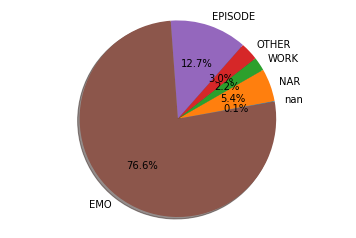

In [19]:
labels = list(set(emotion_pd.TAG))
sizes = [Counter(list(emotion_pd.TAG))[x] for x in labels] 
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

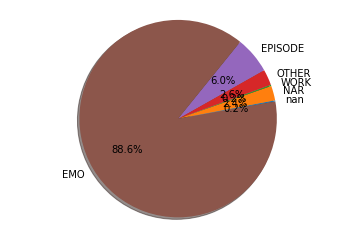

In [20]:
# Первые 500 записей

labels = list(set(emotion_pd.TAG))
sizes = [Counter(list(emotion_pd.TAG)[:500])[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')   

plt.show()

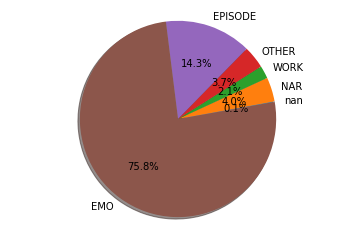

In [8]:
# с 500 по 1500

labels = list(set(emotion_pd.TAG))
sizes = [Counter(list(emotion_pd.TAG)[500:1500])[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

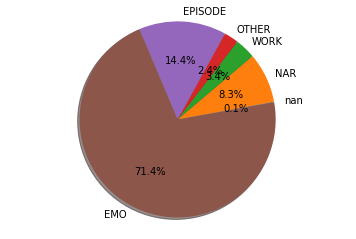

In [9]:
# с 1500 по 2500

labels = list(set(emotion_pd.TAG))
sizes = [Counter(list(emotion_pd.TAG)[1500:2500])[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Анализ разметки для WORK

In [23]:
work_pd = pd.read_csv("./corpus_for_annotators/base_corpuses/work_corpus.csv", sep = "\t")

In [24]:
work_pd = work_pd.sort_values("WORK_PRED", ascending=False)

In [25]:
work_pd.head()

,notes,id,note_id,TAG,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,PRED
1085,"Состоялось Всесоюзное совещание энергетиков, н...",468,291018,WORK,0.010,0.024,0.949,0.017,WORK
1086,На заседании Президиума Совета Министров СССР ...,468,322452,WORK,0.017,0.018,0.948,0.017,WORK
1087,"Состоялось заседание коллегии министерства, на...",468,283466,WORK,0.011,0.017,0.947,0.024,WORK
1088,С группой экспертов мы находились на совещании...,468,289982,WORK,0.015,0.020,0.944,0.021,WORK
1089,На заседании коллегии Минэнерго информировал о...,468,335148,WORK,0.010,0.028,0.936,0.027,WORK


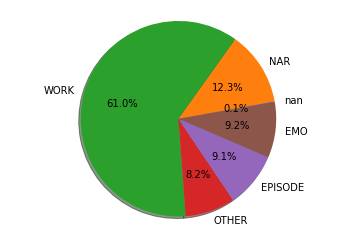

In [26]:
labels = list(set(work_pd.TAG))
sizes = [Counter(list(work_pd.TAG))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

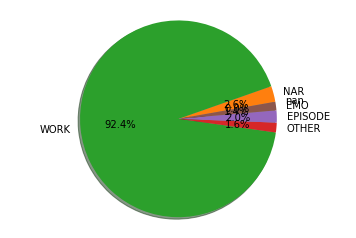

In [27]:
labels = list(set(work_pd.TAG))
sizes = [Counter(list(work_pd.TAG[:500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

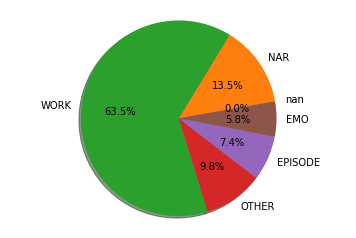

In [28]:
labels = list(set(work_pd.TAG))
sizes = [Counter(list(work_pd.TAG[500:1500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

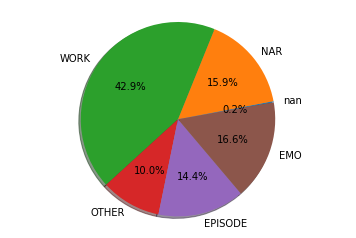

In [29]:
labels = list(set(work_pd.TAG))
sizes = [Counter(list(work_pd.TAG[1500:2500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Анализ разметки EPISODE

In [30]:
episode_pd = pd.read_csv("./corpus_for_annotators/base_corpuses/episode_corpus.csv", sep = "\t") 

In [31]:
episode_pd = episode_pd.sort_values("EPISODE_PRED", ascending=False)

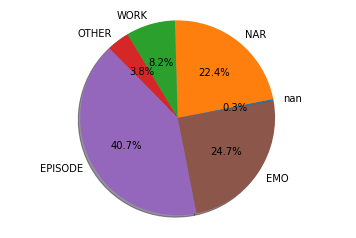

In [32]:
labels = list(set(episode_pd.TAG))
sizes = [Counter(list(episode_pd.TAG))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

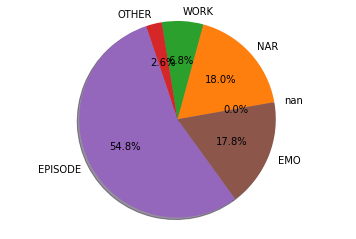

In [33]:
labels = list(set(episode_pd.TAG))
sizes = [Counter(list(episode_pd.TAG[:500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

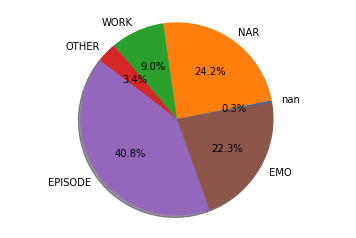

In [34]:
labels = list(set(episode_pd.TAG))
sizes = [Counter(list(episode_pd.TAG[500:1500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

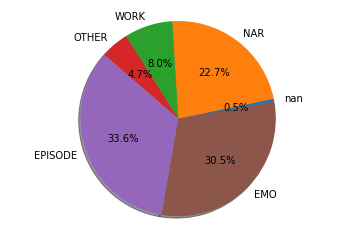

In [35]:
labels = list(set(episode_pd.TAG))
sizes = [Counter(list(episode_pd.TAG[1500:2500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Анализ разметки NAR

In [36]:
nar_pd = pd.read_csv("./corpus_for_annotators/base_corpuses/nar_corpus.csv", sep = "\t") 

In [37]:
nar_pd = nar_pd.sort_values("NAR_PRED", ascending=False)

In [38]:
nar_pd.head()

,notes,id,note_id,TAG,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,PRED
0,*Вторник.* Был отличный теплый день. \nПосл...,183,60197,NAR,0.041,0.090,0.064,0.805,NAR
1,Вторник. Газеты полны подробностей об убийстве...,13,104090,NAR,0.053,0.048,0.094,0.805,NAR
2,**Понедельник**. Десятый день стоят сильные мо...,1639,161074,NAR,0.050,0.109,0.064,0.776,NAR
3,Среда. День ясный и тёплый. ... \nСегодня у...,589,257275,NAR,0.056,0.079,0.095,0.770,NAR
4,"**Вербное** **воскресение.** +1, туман. ... ...",589,256432,NAR,0.089,0.089,0.068,0.753,NAR


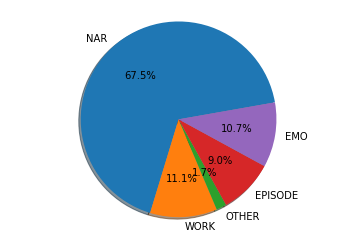

In [39]:
labels = list(set(nar_pd.TAG))
sizes = [Counter(list(nar_pd.TAG))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

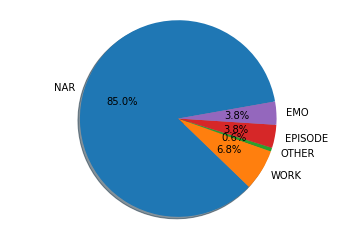

In [40]:
labels = list(set(nar_pd.TAG))
sizes = [Counter(list(nar_pd.TAG[:500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

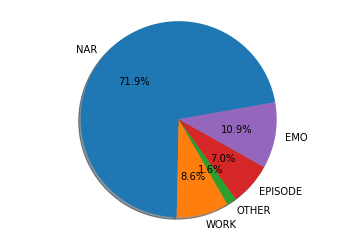

In [41]:
labels = list(set(nar_pd.TAG))
sizes = [Counter(list(nar_pd.TAG[500:1500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

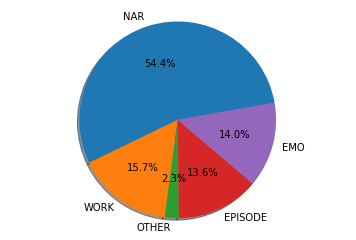

In [42]:
labels = list(set(nar_pd.TAG))
sizes = [Counter(list(nar_pd.TAG[1500:2500]))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Объединение разметки, смотрим на общую картину

In [43]:
united_table = pd.concat([emotion_pd, episode_pd, work_pd, nar_pd]).reset_index()

In [44]:
united_table.head()

,index,notes,id,note_id,TAG,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,PRED
0,0,"Я не могу хорошенько понять, что со мной делае...",870,158364,EMO,0.862,0.064,0.015,0.059,EMO
1,1,"(Среда) \nЛида, что с тобой делается? Взошл...",1969,76187,EMO,0.851,0.064,0.026,0.059,EMO
2,2,Жду поездку домой как величайшего праздника. Д...,46,337412,EMO,0.826,0.057,0.034,0.084,EMO
3,3,[...] Илюша вдруг заговорил как-то особенно хо...,120,155957,EMO,0.817,0.078,0.029,0.076,EMO
4,4,"Уже прошло 6 дней, а Вали нет, я ожидала его к...",1574,135700,EMO,0.813,0.047,0.021,0.120,EMO


In [45]:
# accuracy 

In [46]:
evens = list([united_table.TAG == united_table.PRED][0])

In [47]:
sum(evens)/len(evens)

0.6147

In [48]:
len(united_table)

10000

In [49]:
len(set(united_table.note_id))

9947

In [50]:
def delete_dublets(table):
    """ удаляем дубли из таблички """
    table_ids = {} 
    for index, x in enumerate(table.note_id):
        if x not in table_ids: 
            table_ids[x] = index
        else:
            continue
    table_without_dublets = table[table.index.isin(table_ids.values())].sort_values("note_id")
    return table_without_dublets

In [51]:
clear_table = delete_dublets(united_table)

### Сравниваем с разметкой аннотаторов

In [52]:
table_1 = pd.read_excel("./marked_by_annotators/corpus_part_1.xlsx")
table_2 = pd.read_excel("./marked_by_annotators/corpus_part_2.xlsx")
table_3 = pd.read_excel("./marked_by_annotators/corpus_part_3.xlsx")
table_5 = pd.read_excel("./marked_by_annotators/corpus_part_5.xlsx")
table_8 = pd.read_excel("./marked_by_annotators/corpus_part_8.xlsx")
table_9 = pd.read_excel("./marked_by_annotators/corpus_part_9.xlsx")

In [53]:
annotator_table = delete_dublets(pd.concat([table_1, table_5, table_3, table_2, table_8, table_9]).reset_index())

In [54]:
annotator_table.head()

,index,Unnamed: 0,note_id,notes,id,PRED,TRUE_TAG,TAG,TAG-2
5071,71,321,10,"25, в Минск, где его милость пан Гетман польны...",1081,WORK,1,NaN,NaN
4872,872,522,46,1 Его Королевское Величество со всем своим вой...,1081,WORK,1,WORK,NaN
209,209,1993,3668,Среда. После обеда отправились мы в Тулу. По в...,772,EMO,0,EPISODE,NaN
4633,633,841,3669,Четверг. Сего числа к ночи прибыли мы в Тулу. ...,772,NAR,1,NAR,NaN
509,509,1023,3716,Приехали на Макарьевскую ярмарку. Поутру ездил...,1740,EPISODE,0,NAR,NaN


In [55]:
a = [int(x) for x in annotator_table.TRUE_TAG if (x == 0 or x == 1)]
sum(a)/len(a)

0.6958633394741249

In [56]:
golds = []
for i, t in enumerate(annotator_table["TRUE_TAG"]):
    if t == 1:
        golds.append(annotator_table.PRED.iloc[i])
    else:
        golds.append(annotator_table.TAG.iloc[i])

In [57]:
annotator_table["GOLD"] = golds

In [58]:
big_ids = set(clear_table["note_id"])
ann_ids = set(annotator_table["note_id"])

common_ids = list(big_ids&ann_ids)

In [59]:
len(common_ids)

5988

In [60]:
annotator_gold_1 = clear_table[clear_table.note_id.isin(common_ids)].sort_values("note_id")
annotator_gold_2 = annotator_table[annotator_table.note_id.isin(common_ids)].sort_values("note_id")

In [61]:
len(annotator_gold_1), len(annotator_gold_2)

(5988, 5988)

In [62]:
one_preds = list(annotator_gold_1["TAG"])
two_preds = list(annotator_gold_2["GOLD"])

In [63]:
my_tags = ["EPISODE", "EMO", "NAR", "WORK"]

In [64]:
preds_one = []
preds_two = []

for i, tag in enumerate(one_preds): 
    if tag not in my_tags:
        continue
    elif two_preds[i] not in my_tags:
        continue
    else:
        preds_one.append(tag)
        preds_two.append(two_preds[i])

In [65]:
len(preds_two), len(preds_one)

(5640, 5640)

In [66]:
quality = []

for i, tag in enumerate(one_preds):
    if (tag not in my_tags) or (two_preds[i] not in my_tags):
        continue
    elif tag == two_preds[i]:
        quality.append(1)
    else:
        quality.append(0)
        
sum(quality)/len(quality)

0.6702127659574468

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [68]:
len(preds_two)

5640

In [69]:
print(classification_report(preds_one, preds_two))

              precision    recall  f1-score   support

         EMO       0.80      0.70      0.74      1826
     EPISODE       0.48      0.53      0.51      1068
         NAR       0.64      0.64      0.64      1548
        WORK       0.72      0.79      0.75      1198

    accuracy                           0.67      5640
   macro avg       0.66      0.67      0.66      5640
weighted avg       0.68      0.67      0.67      5640



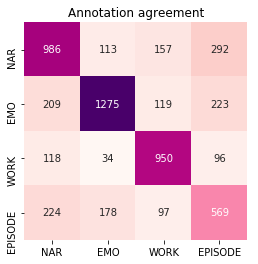

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

labels = ["NAR", "EMO", "WORK", "EPISODE"]
m = confusion_matrix(preds_one, preds_two, labels) 

 
plt.figure(figsize = (4,4))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Annotation agreement")
plt.show()

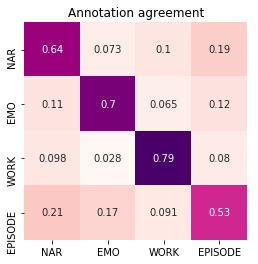

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

labels = ["NAR", "EMO", "WORK", "EPISODE"]
m = confusion_matrix(preds_one, preds_two, labels)
m = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

 
plt.figure(figsize = (4,4))
sns.heatmap(data=m, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Annotation agreement")
plt.show()

### Смотрим для трёх категорий

In [72]:
uni_preds_one = ["NAR_EPISODE" if x in ["NAR", "EPISODE"] else x for x in preds_one]
uni_preds_two = ["NAR_EPISODE" if x in ["NAR", "EPISODE"] else x for x in preds_two]

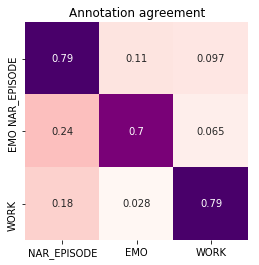

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

labels = ["NAR_EPISODE", "EMO", "WORK"]
m = confusion_matrix(uni_preds_one, uni_preds_two, labels) 
m = m.astype('float') / m.sum(axis=1)[:, np.newaxis]
 
plt.figure(figsize = (4,4))
sns.heatmap(data=m, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Annotation agreement")
plt.show()

### Отбираем "хорошие" данные

In [74]:
annotator_gold_1["TAG_TWO"] = two_preds

In [75]:
annotator_gold_1[(annotator_gold_1.TAG_TWO == "EMO") & (annotator_gold_1.TAG == "WORK")].notes.iloc[3]

'Пятница. Гр. Протасов-Бахметев назначен главноуправляющим Собственною канцеляриею по делам императрицы Марии. Это прекрасный в нравственном смысле человек, безукоризненно честный, правдивый, добросовестный, но при весьма ограниченном кругозоре, не имеющий понятия ни о государственном, ни о каком бы то ни было ином управлении. Он весь пропадет на мелочах, а большими делами будет вертеть первый, кто им овладеет и притом весьма легко овладеет.    \nВечером в клубе разговор с Абазою об обуховском деле, подлежащем докладу на следующий день. Абаза находит единственно правильным основанием к разрешению этого дела удовлетворение ходатайства Николая Левашева о возвращении пайщиками истраченной ими на покупку паев суммы.'

In [76]:
gold_table = annotator_gold_1[annotator_gold_1.TAG == annotator_gold_1.TAG_TWO]
gold_table = gold_table[gold_table.TAG != "OTHER"]

In [77]:
len(gold_table) 

3780

In [78]:
def normalize(text):    
    """ токенизируем текст и убираем стоп-слова """
    words = text.lower().split()
    words = [word.strip(punct+" ") for word in words]
    words = [word for word in words if word and word not in stops] 

    return words

In [79]:
Counter(gold_table.TAG).most_common()

[('EMO', 1275), ('NAR', 986), ('WORK', 950), ('EPISODE', 569)]

In [80]:
def get_corpus_by_tag(table, tag, tag_text):
    """ собираем корпуск текстов с одним тегом """
    corpus = ""
    table_tag = table[table.TAG == tag]
    for x in table_tag[tag_text]:
        corpus += " ".join(x) + "\n"
    return corpus

In [81]:
gold_table["words"] = gold_table["notes"].apply(lambda x: normalize(x))

In [82]:
emo_corpus = get_corpus_by_tag(gold_table, "EMO", "words")
work_corpus = get_corpus_by_tag(gold_table, "WORK", "words")
nar_corpus = get_corpus_by_tag(gold_table, "NAR", "words")
episode_corpus = get_corpus_by_tag(gold_table, "EPISODE", "words")

In [83]:
tfidf_for_corpuses = TfidfVectorizer(ngram_range=(1,1), min_df=1)
X_corpus = tfidf_for_corpuses.fit_transform([emo_corpus, work_corpus, nar_corpus, episode_corpus])

id2word = {i:word for i,word in enumerate(tfidf_for_corpuses.get_feature_names())}
texts_vectors_corpus = tfidf_for_corpuses.transform([emo_corpus, work_corpus, nar_corpus, episode_corpus])
keywords_corpus = [[id2word[w] for w in top] for top in texts_vectors_corpus.toarray().argsort()[:,:-21:-1]] 

In [84]:
emo_keys, work_keys, nar_keys, episode_keys = keywords_corpus[0], keywords_corpus[1], keywords_corpus[2], keywords_corpus[3]

In [85]:
len(emo_keys)

20

In [86]:
len(set(emo_keys) & set(episode_keys)), len(set(nar_keys) & set(episode_keys))

(7, 11)

In [87]:
len(set(nar_keys) & set(emo_keys)), len(set(nar_keys) & set(work_keys)), len(set(emo_keys) & set(work_keys))

(8, 6, 5)

In [88]:
tfidf_for_corpuses = TfidfVectorizer(ngram_range=(2,3), min_df=1)
X_corpus = tfidf_for_corpuses.fit_transform([emo_corpus, work_corpus, nar_corpus, episode_corpus])

id2word = {i:word for i,word in enumerate(tfidf_for_corpuses.get_feature_names())}
texts_vectors_corpus = tfidf_for_corpuses.transform([emo_corpus, work_corpus, nar_corpus, episode_corpus])
keywords_corpus = [[id2word[w] for w in top] for top in texts_vectors_corpus.toarray().argsort()[:,:-11:-1]] 

In [89]:
emo_keys, work_keys, nar_keys, episode_keys = keywords_corpus[0], keywords_corpus[1], keywords_corpus[2], keywords_corpus[3]

In [90]:
len(set(emo_keys) & set(episode_keys)), len(set(nar_keys) & set(episode_keys))

(8, 5)

In [91]:
len(set(nar_keys) & set(emo_keys)), len(set(nar_keys) & set(work_keys)), len(set(emo_keys) & set(work_keys))

(5, 1, 1)

In [92]:
X, y, author = gold_table.notes, gold_table.TAG, gold_table.id
X_train, X_test, y_train, y_test, author_train, author_test = train_test_split(X, y, author, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10) #BOW + TF-IDF
tfidf_word = TfidfVectorizer(ngram_range=(1,4), min_df=15) #BOW + TF-IDF
classifier_tfidf = LogisticRegression(solver='newton-cg', multi_class='multinomial') #мультиклассовая 
classifier_NB = MultinomialNB()

In [93]:
clf_tfidf = Pipeline([
    ('vect', tfidf),
    ('clf', classifier_tfidf),
])

# учим классификатор
%time clf_tfidf.fit(X_train, y_train)

CPU times: user 4.3 s, sys: 1.92 s, total: 6.22 s
Wall time: 2.75 s


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=10, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [94]:
predictions_tfidf = clf_tfidf.predict(X_test)

In [95]:
def evaluate(true, predicted):

    # макро-усреднение
    print("Precision: {0:6.2f}".format(precision_score(true, predicted, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(true, predicted, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(true, predicted, average='macro')))

    print("...")
    # микро-усреднение
    print("Precision: {0:6.2f}".format(precision_score(true, predicted, average='micro')))
    print("Recall: {0:6.2f}".format(recall_score(true, predicted, average='micro')))
    print("F1-measure: {0:6.2f}".format(f1_score(true, predicted, average='micro')))

    print("...")
    # accuracy
    print("Accuracy: {0:6.2f}".format(accuracy_score(true, predicted)))

In [96]:
evaluate(y_test, predictions_tfidf)

Precision:   0.79
Recall:   0.74
F1-measure:   0.75
...
Precision:   0.80
Recall:   0.80
F1-measure:   0.80
...
Accuracy:   0.80


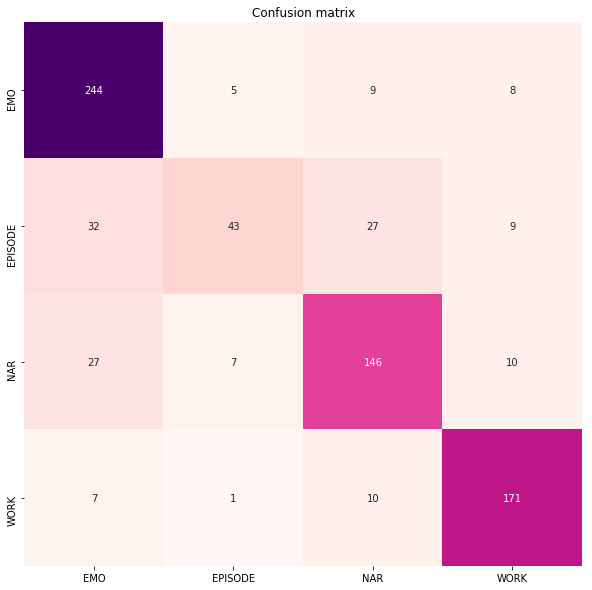

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(y_test, predictions_tfidf)

labels = clf_tfidf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Confusion matrix")
plt.show()

### Балансируем датасет

In [104]:
episode_table = gold_table[gold_table.TAG == "EPISODE"].sample(560)
emo_table = gold_table[gold_table.TAG == "EMO"].sample(560)
nar_table = gold_table[gold_table.TAG == "NAR"].sample(560)
work_table = gold_table[gold_table.TAG == "WORK"].sample(560)

balanced_dataset = pd.concat([episode_table, emo_table, nar_table, work_table])

In [105]:
train, test = train_test_split(balanced_dataset, test_size = 0.2) 

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10) #BOW + TF-IDF
tfidf_word = TfidfVectorizer(ngram_range=(1,4), min_df=15) #BOW + TF-IDF
classifier_tfidf = LogisticRegression(solver='newton-cg', multi_class='multinomial') #мультиклассовая  

In [106]:
clf_tfidf = Pipeline([
    ('vect', tfidf),
    ('clf', classifier_tfidf),
])

# учим классификатор
%time clf_tfidf.fit(train.notes, train.TAG)

CPU times: user 2.42 s, sys: 1.03 s, total: 3.45 s
Wall time: 1.52 s


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=10, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [107]:
predictions_tfidf = clf_tfidf.predict(test.notes)

In [108]:
evaluate(test.TAG, predictions_tfidf)

Precision:   0.79
Recall:   0.79
F1-measure:   0.79
...
Precision:   0.79
Recall:   0.79
F1-measure:   0.79
...
Accuracy:   0.79


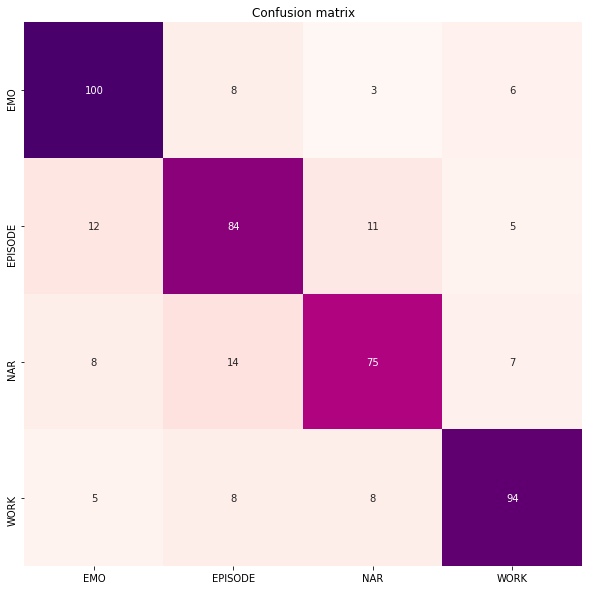

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.TAG, predictions_tfidf)

labels = clf_tfidf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Confusion matrix")
plt.show()

#### Формируем тест и трейн

In [110]:
# сбалансированный
#train.to_csv("./balanced_dataset/train.csv", sep = "\t")
#test.to_csv("./balanced_dataset/test.csv", sep = "\t")

In [112]:
# несбалансированный
untrain, untest = train_test_split(gold_table, test_size = 0.2) 

In [114]:
#untrain.to_csv("./unbalanced_dataset/train.csv", sep = "\t")
#untest.to_csv("./unbalanced_dataset/test.csv", sep = "\t")

In [116]:
len(gold_table)

3780

### Анализ Лансере

In [150]:
lansere_table = pd.read_csv("lansere.csv", sep = "\t")

In [151]:
predictions_lansere = clf_tfidf.predict(lansere_table.notes)

In [152]:
predictions_lansere

array(['EPISODE', 'NAR', 'EMO', ..., 'EMO', 'NAR', 'EMO'], dtype=object)

In [153]:
len(predictions_lansere)

1274

In [154]:
lansere_table["age"] = lansere_table.dates.apply(lambda x: int(x.split("/")[0])-1893+18)

In [155]:
lansere_table

,Unnamed: 0,Unnamed: 0.1,notes,dates,id,author,length,russian,poetry,note_id,age
0,11326,43000,Суббота. Солнце! Великое Солнце! Почти вся эта...,1893/2/25,877,Евгений Евгеньевич Лансере,592,True,False,43000,18
1,11330,43017,Среда. 3 часа дня. Как сегодня хорошо. Сегодня...,1893/3/1,877,Евгений Евгеньевич Лансере,1030,True,False,43017,18
2,11334,43029,11 часов вечера. <...> Принялся за пейзаж с 3 ...,1893/3/3,877,Евгений Евгеньевич Лансере,888,True,False,43029,18
3,11347,43076,"Понедельник. 4 ч. дня. <...> Серое небо, грязн...",1893/3/13,877,Евгений Евгеньевич Лансере,927,True,False,43076,18
4,11348,43077,Понедельник. 10 часов вечера. Сегодня во время...,1893/3/13,877,Евгений Евгеньевич Лансере,1033,True,False,43077,18
5,11367,43143,Понедельник 1893 г. 11 часов вечера. Вчера у н...,1893/3/27,877,Евгений Евгеньевич Лансере,1153,True,False,43143,18
6,11372,43171,Воскресенье. 12-4 ч. дня. <...> Читал : 1) о л...,1893/4/2,877,Евгений Евгеньевич Лансере,632,True,False,43171,18
7,11394,43262,Вторник. СПБ. 8 часов вечера. <...> Нева еще д...,1893/4/18,877,Евгений Евгеньевич Лансере,758,True,False,43262,18
8,11400,43277,"Пятница. <...> После завтрака, дядя Коля, мама...",1893/4/21,877,Евгений Евгеньевич Лансере,569,True,False,43277,18
9,11410,43325,Суббота. (Боже! Как время скоро идет). 9 1/2 в...,1893/4/29,877,Евгений Евгеньевич Лансере,900,True,False,43325,18


In [167]:
lansere_table[(lansere_table.age > 25) & (lansere_table.age < 60)]

,Unnamed: 0,Unnamed: 0.1,notes,dates,id,author,length,russian,poetry,note_id,age
142,16230,59631,Понедельник. 1 ч. дня. Вчера мы были на «Трёх ...,1901/4/1,877,Евгений Евгеньевич Лансере,1449,True,False,59631,26
143,16408,60156,Среда. Вечером. \n### Черновик письма барону...,1901/7/3,877,Евгений Евгеньевич Лансере,600,True,False,60156,26
144,16460,60328,Нескучное. \n### Черновик письма Н. И. Кутеп...,1901/8/2,877,Евгений Евгеньевич Лансере,1084,True,False,60328,26
145,16464,60335,\n### Черновик письма Н.Е. Лансере. \nД...,1901/8/3,877,Евгений Евгеньевич Лансере,1034,True,False,60335,26
146,16516,60441,\n### Черновик письма неизвестному лицу. ...,1901/8/25,877,Евгений Евгеньевич Лансере,1362,True,False,60441,26
147,16783,61106,"10/11. Книгоиздательство «Скорпион», Москва, Ю...",1901/12/4,877,Евгений Евгеньевич Лансере,1194,True,False,61106,26
148,16841,61262,\n### В Гатчино Н.И. Кутепову. \nМногоу...,1901/12/24,877,Евгений Евгеньевич Лансере,1363,True,False,61262,26
149,17215,62348,\n### Черновик письма А.П. Остроумовой. ...,1902/5/15,877,Евгений Евгеньевич Лансере,584,True,False,62348,27
150,17256,62454,Эти записки будут вестись исключительно с «опр...,1902/6/1,877,Евгений Евгеньевич Лансере,1381,True,False,62454,27
151,17293,62557,\n### Заметки. \nПодъезжая к Канску Зап...,1902/6/25,877,Евгений Евгеньевич Лансере,985,True,False,62557,27


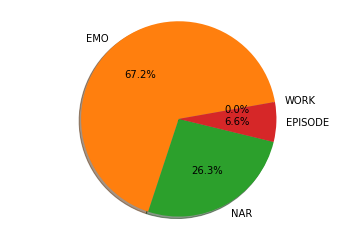

In [160]:
labels = list(set(predictions_lansere))
sizes = [Counter(list(predictions_lansere)[0:137])[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

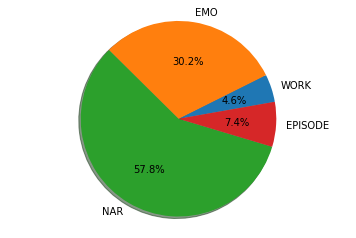

In [168]:
labels = list(set(predictions_lansere))
sizes = [Counter(list(predictions_lansere)[137:812])[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()